原文代码作者：François Chollet

github：https://github.com/fchollet/deep-learning-with-python-notebooks

中文注释制作：黄海广

github：https://github.com/fengdu78

代码全部测试通过。

配置环境：keras 2.2.1（原文是2.0.8，运行结果一致），tensorflow 1.8，python 3.6，

主机：显卡：一块1080ti；内存：32g（注：绝大部分代码不需要GPU）
![公众号](data/gongzhong.jpg)

In [1]:
import keras
keras.__version__

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.2.4'

# Using a pre-trained convnet
# 使用预训练的卷积神经网络

This notebook contains the code sample found in Chapter 5, Section 3 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network 
is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original 
dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a 
generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these 
new problems might involve completely different classes from those of the original task. For instance, one might train a network on 
ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as 
identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning 
compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes). 
ImageNet contains many animal classes, including different species of cats and dogs, and we can thus expect to perform very well on our cat 
vs. dog classification problem.

We will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture 
for ImageNet. Although it is a bit of an older model, far from the current state of the art and somewhat heavier than many other recent 
models, we chose it because its architecture is similar to what you are already familiar with, and easy to understand without introducing 
any new concepts. This may be your first encounter with one of these cutesie model names -- VGG, ResNet, Inception, Inception-ResNet, 
Xception... you will get used to them, as they will come up frequently if you keep doing deep learning for computer vision.

There are two ways to leverage a pre-trained network: *feature extraction* and *fine-tuning*. We will cover both of them. Let's start with 
feature extraction.


想要将深度学习应用于小型图像数据集，一种常用且非常高效的方法是使用预训练网络。 预训练网络（pretrained network）是一个保存好的网络，之前已在大型数据集（通常是大规模图像分类任务）上训练好。如果这个原始数据集足够大且足够通用，那么预训练网络学到的特征的空间层次结构可以有效地作为视觉世界的通用模型，因此这些特征可用于各种不同的计算机视觉问题，即使这些新问题涉及的类别和原始任务完全不同。举个例子，你在 ImageNet 上训练了一个网络（其类别主要是动物和日常用品），然后将这个训练好的网络应用于某个不相干的任务，比如在图像中识别家具。这种学到的特征在不同问题之间的可移植性，是深度学习与许多早期浅层学习方法相比的重要优势，它使得深度学习对小数据问题非常有效。

本例中，假设有一个在 ImageNet 数据集（140 万张标记图像，1000 个不同的类别）上训练好的大型卷积神经网络。ImageNet 中包含许多动物类别，其中包括不同种类的猫和狗，因此可以认为它在猫狗分类问题上也能有良好的表现。

我们将使用 VGG16 架构，它由 Karen Simonyan 和 Andrew Zisserman 在 2014 年开发。对于ImageNet，它是一种简单而又广泛使用的卷积神经网络架构。虽然 VGG16 是一个比较旧的模 型，性能远比不了当前最先进的模型，而且还比许多新模型更为复杂，但我之所以选择它，是因为它的架构与你已经熟悉的架构很相似，因此无须引入新概念就可以很好地理解。这可能是你第一次遇到这种奇怪的模型名称——VGG、ResNet、Inception、Inception-ResNet、Xception 等。 你会习惯这些名称的，因为如果你一直用深度学习做计算机视觉的话，它们会频繁出现。

使用预训练网络有两种方法：特征提取（feature extraction）和微调模型（fine-tuning）。两种方法我们都会介绍。首先来看特征提取。



## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. 
These features are then run through a new classifier, which is trained from scratch.

As we saw previously, convnets used for image classification comprise two parts: they start with a series of pooling and convolution 
layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of 
convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data 
through it, and training a new classifier on top of the output.

## 特征提取

特征提取是使用之前网络学到的表示来从新样本中提取出有趣的特征。然后将这些特征输入一个新的分类器，从头开始训练。

如前所述，用于图像分类的卷积神经网络包含两部分：首先是一系列池化层和卷积层，最后是一个密集连接分类器。第一部分叫作模型的卷积基（convolutional base）。对于卷积神经网络而言，特征提取就是取出之前训练好的网络的卷积基，在上面运行新数据，然后在输出上面 训练一个新的分类器（见下图）。


![swapping FC classifiers](data/swapping_fc_classifier.png)

Why only reuse the convolutional base? Could we reuse the densely-connected classifier as well? In general, it should be avoided. The 
reason is simply that the representations learned by the convolutional base are likely to be more generic and therefore more reusable: the 
feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer 
vision problem at hand. On the other end, the representations learned by the classifier will necessarily be very specific to the set of 
classes that the model was trained on -- they will only contain information about the presence probability of this or that class in the 
entire picture. Additionally, representations found in densely-connected layers no longer contain any information about _where_ objects are 
located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional 
feature maps. For problems where object location matters, densely-connected features would be largely useless.

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on 
the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual 
edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "cat ear" or "dog eye"). So if your new 
dataset differs a lot from the dataset that the original model was trained on, you may be better off using only the first few layers of the 
model to do feature extraction, rather than using the entire convolutional base.

In our case, since the ImageNet class set did contain multiple dog and cat classes, it is likely that it would be beneficial to reuse the 
information contained in the densely-connected layers of the original model. However, we will chose not to, in order to cover the more 
general case where the class set of the new problem does not overlap with the class set of the original model.

为什么仅重复使用卷积基？我们能否也重复使用密集连接分类器？一般来说，应该避免这么做。原因在于卷积基学到的表示可能更加通用，因此更适合重复使用。卷积神经网络的特征图表示通用概念在图像中是否存在，无论面对什么样的计算机视觉问题，这种特征图都可能很有用。但是，分类器学到的表示必然是针对于模型训练的类别，其中仅包含某个类别出现在整张图像中的概率信息。此外，密集连接层的表示不再包含物体在输入图像中的位置信息。密集连接层舍弃了空间的概念，而物体位置信息仍然由卷积特征图所描述。如果物体位置对于问题 很重要，那么密集连接层的特征在很大程度上是无用的。

注意，某个卷积层提取的表示的通用性（以及可复用性）取决于该层在模型中的深度。模型中更靠近底部的层提取的是局部的、高度通用的特征图（比如视觉边缘、颜色和纹理），而更靠近顶部的层提取的是更加抽象的概念（比如“猫耳朵”或“狗眼睛”）。 因此，如果你的新数据集与原始模型训练的数据集有很大差异，那么最好只使用模型的前几层来做特征提取，而不是使用整个卷积基。

本例中，由于 ImageNet 的类别中包含多种狗和猫的类别，所以重复使用原始模型密集连接层中所包含的信息可能很有用。但我们选择不这么做，以便涵盖新问题的类别与原始模型的类别不一致的更一般情况。

Let's put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from 
our cat and dog images, and then training a cat vs. dog classifier on top of these features.

The VGG16 model, among others, comes pre-packaged with Keras. You can import it from the `keras.applications` module. Here's the list of 
image classification models (all pre-trained on the ImageNet dataset) that are available as part of `keras.applications`:

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

Let's instantiate the VGG16 model:

我们来实践一下，使用在 ImageNet 上训练的 VGG16 网络的卷积基从 猫狗图像中提取有趣的特征，然后在这些特征上训练一个猫狗分类器。
VGG16 等模型内置于 Keras 中。你可以从 keras.applications 模块中导入。下面是keras.applications 中的一部分图像分类模型（都是在 ImageNet 数据集上预训练得到的）：
* Xception
* Inception V3
* ResNet50
* VGG16
* VGG19
* MobileNet
我们将 VGG16 模型实例化。


In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

We passed three arguments to the constructor:

* `weights`, to specify which weight checkpoint to initialize the model from
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this 
densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected 
classifier (with only two classes, cat and dog), we don't need to include it.
* `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, 
then the network will be able to process inputs of any size.

Here's the detail of the architecture of the VGG16 convolutional base: it's very similar to the simple convnets that you are already 
familiar with.

这里向构造函数中传入了三个参数。
* weights 指定模型初始化的权重检查点。
* include_top 指定模型最后是否包含密集连接分类器。默认情况下，这个密集连接分类器对应于 ImageNet 的 1000 个类别。因为我们打算使用自己的密集连接分类器（只有 两个类别：cat 和 dog），所以不需要包含它。
* input_shape 是输入到网络中的图像张量的形状。这个参数完全是可选的，如果不传入这个参数，那么网络能够处理任意形状的输入。
VGG16 卷积基的详细架构如下所示。它和你已经熟悉的简单卷积神经网络很相似。


In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

The final feature map has shape `(4, 4, 512)`. That's the feature on top of which we will stick a densely-connected classifier.

At this point, there are two ways we could proceed: 

* Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a 
standalone densely-connected classifier similar to those you have seen in the first chapters of this book. This solution is very fast and 
cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the 
most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at 
all.
* Extending the model we have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end-to-end on the input data. This 
allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. 
However, for this same reason, this technique is far more expensive than the first one.

We will cover both techniques. Let's walk through the code required to set-up the first one: recording the output of `conv_base` on our 
data and using these outputs as inputs to a new model.

We will start by simply running instances of the previously-introduced `ImageDataGenerator` to extract images as Numpy arrays as well as 
their labels. We will extract features from these images simply by calling the `predict` method of the `conv_base` model.

最后的特征图形状为 (4, 4, 512)。我们将在这个特征上添加一个密集连接分类器。 接下来，下一步有两种方法可供选择。
* 在你的数据集上运行卷积基，将输出保存成硬盘中的 Numpy 数组，然后用这个数据作 为输入，输入到独立的密集连接分类器中（与本书第一部分介绍的分类器类似）。这种 方法速度快，计算代价低，因为对于每个输入图像只需运行一次卷积基，而卷积基是目 前流程中计算代价最高的。但出于同样的原因，这种方法不允许你使用数据增强。
* 在顶部添加 Dense 层来扩展已有模型（即 conv_base），并在输入数据上端到端地运行 整个模型。这样你可以使用数据增强，因为每个输入图像进入模型时都会经过卷积基。但出于同样的原因，这种方法的计算代价比第一种要高很多。

这两种方法我们都会介绍。首先来看第一种方法的代码：保存你的数据在 conv_base 中的输出，然后将这些输出作为输入用于新模型。


In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'data/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            #注意，这些生成器在循环中不断生成数据，所以你必须在读取完所有图像后终止循环
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The extracted features are currently of shape `(samples, 4, 4, 512)`. We will feed them to a densely-connected classifier, so first we must 
flatten them to `(samples, 8192)`:

目前，提取的特征形状为 (samples, 4, 4, 512)。我们要将其输入到密集连接分类器中， 所以首先必须将其形状展平为 (samples, 8192)。

In [5]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and 
labels that we just recorded:

现在你可以定义你的密集连接分类器（注意要使用 dropout 正则化），并在刚刚保存的数据和标签上训练这个分类器。

In [6]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.5879 - acc: 0.6915 - val_loss: 0.4312 - val_acc: 0.8290
Epoch 2/30
2000/2000 [==============================] - 2s 866us/step - loss: 0.4309 - acc: 0.7975 - val_loss: 0.3643 - val_acc: 0.8530
Epoch 3/30
2000/2000 [==============================] - 2s 836us/step - loss: 0.3675 - acc: 0.8440 - val_loss: 0.3273 - val_acc: 0.8700
Epoch 4/30
2000/2000 [==============================] - 2s 837us/step - loss: 0.3183 - acc: 0.8660 - val_loss: 0.3001 - val_acc: 0.8810
Epoch 5/30
2000/2000 [==============================] - 2s 853us/step - loss: 0.2856 - acc: 0.8815 - val_loss: 0.2916 - val_acc: 0.8790
Epoch 6/30
2000/2000 [==============================] - 2s 860us/step - loss: 0.2750 - acc: 0.8835 - val_loss: 0.2782 - val_acc: 0.8870
Epoch 7/30
2000/2000 [==============================] - 2s 843us/step - loss: 0.2460 - acc: 0.9060 - val_loss: 0.2722 - val_acc: 0.8840
Ep

Training is very fast, since we only have to deal with two `Dense` layers -- an epoch takes less than one second even on CPU.

Let's take a look at the loss and accuracy curves during training:

训练速度非常快，因为你只需处理两个 Dense 层。即使在 CPU 上运行，每轮的时间也不到一秒钟。

我们来看一下训练期间的损失曲线和精度曲线


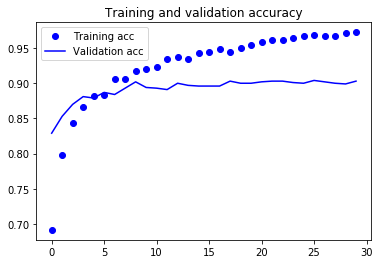

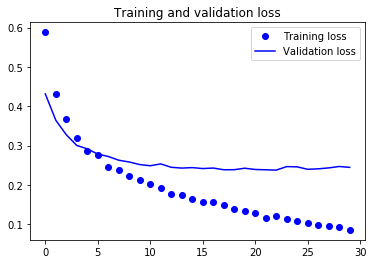

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


We reach a validation accuracy of about 90%, much better than what we could achieve in the previous section with our small model trained from 
scratch. However, our plots also indicate that we are overfitting almost from the start -- despite using dropout with a fairly large rate. 
This is because this technique does not leverage data augmentation, which is essential to preventing overfitting with small image datasets.

Now, let's review the second technique we mentioned for doing feature extraction, which is much slower and more expensive, but which allows 
us to leverage data augmentation during training: extending the `conv_base` model and running it end-to-end on the inputs. Note that this 
technique is in fact so expensive that you should only attempt it if you have access to a GPU: it is absolutely intractable on CPU. If you 
cannot run your code on GPU, then the previous technique is the way to go.

Because models behave just like layers, you can add a model (like our `conv_base`) to a `Sequential` model just like you would add a layer. 
So you can do the following:

我们的验证精度达到了约 90%，比上一节从头开始训练的小型模型效果要好得多。但从图中也可以看出，虽然 dropout 比率相当大，但模型几乎从一开始就过拟合。这是因为本方法没有使用数据增强，而数据增强对防止小型图像数据集的过拟合非常重要。

下面我们来看一下特征提取的第二种方法，它的速度更慢，计算代价更高，但在训练期间可以使用数据增强。这种方法就是：扩展 conv_base 模型，然后在输入数据上端到端地运行模型。

模型的行为和层类似，所以你可以向 Sequential 模型中添加一个模型（比如 conv_base），就像添加一个层一样。



In [9]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

This is what our model looks like now:

现在模型的架构如下所示。

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 2 
million parameters.

Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of 
layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were 
previously learned by the convolutional base would get modified during training. Since the `Dense` layers on top are randomly initialized, 
very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, freezing a network is done by setting its `trainable` attribute to `False`:

如你所见，VGG16 的卷积基有 14 714 688 个参数，非常多。在其上添加的分类器有 200 万个参数。

在编译和训练模型之前，一定要“冻结”卷积基。冻结（freeze）一个或多个层是指在训练 过程中保持其权重不变。如果不这么做，那么卷积基之前学到的表示将会在训练过程中被修改。 因为其上添加的 Dense 层是随机初始化的，所以非常大的权重更新将会在网络中传播，对之前学到的表示造成很大破坏。

在 Keras 中，冻结网络的方法是将其 trainable 属性设为 False。


In [14]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [15]:
conv_base.trainable = False

In [16]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per 
layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. 
If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with the same data augmentation configuration that we used in our previous example:

如此设置之后，只有添加的两个 Dense 层的权重才会被训练。总共有 4 个权重张量，每层2 个（主权重矩阵和偏置向量）。注意，为了让这些修改生效，你必须先编译模型。如果在编译之后修改了权重的 trainable 属性，那么应该重新编译模型，否则这些修改将被忽略。
 
现在你可以开始训练模型了，使用和前一个例子相同的数据增强设置。


In [17]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
# 注意，不能增强验证数据
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory（目标目录）
        train_dir,
        # All images will be resized to 150x150（将所有图像的大小调整为 150×150）
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
#         因为使用了 binary_crossentropy损失，所以需要用二进制标签
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 47s - loss: 0.5876 - acc: 0.7010 - val_loss: 0.4451 - val_acc: 0.8200
Epoch 2/30
 - 46s - loss: 0.4781 - acc: 0.7800 - val_loss: 0.3664 - val_acc: 0.8520
Epoch 3/30
 - 46s - loss: 0.4230 - acc: 0.8130 - val_loss: 0.3362 - val_acc: 0.8620
Epoch 4/30
 - 46s - loss: 0.4041 - acc: 0.8195 - val_loss: 0.3115 - val_acc: 0.8700
Epoch 5/30
 - 46s - loss: 0.3848 - acc: 0.8320 - val_loss: 0.2969 - val_acc: 0.8790
Epoch 6/30
 - 46s - loss: 0.3630 - acc: 0.8385 - val_loss: 0.2912 - val_acc: 0.8850
Epoch 7/30
 - 46s - loss: 0.3662 - acc: 0.8335 - val_loss: 0.2773 - val_acc: 0.8910
Epoch 8/30
 - 46s - loss: 0.3510 - acc: 0.8465 - val_loss: 0.2708 - val_acc: 0.8930
Epoch 9/30
 - 46s - loss: 0.3400 - acc: 0.8465 - val_loss: 0.2636 - val_acc: 0.8980
Epoch 10/30
 - 46s - loss: 0.3241 - acc: 0.8655 - val_loss: 0.2636 - val_acc: 0.8980
Epoch 11/30
 - 46s - loss: 0.3388 - acc: 0.8485 - val_loss: 0.2560 - val_ac

In [18]:
model.save('models/cats_and_dogs_small_3.h5')

Let's plot our results again:

再次绘制结果看看。

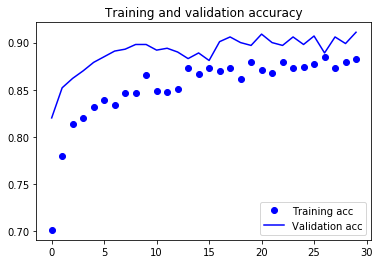

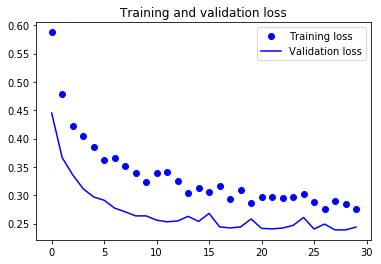

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As you can see, we reach a validation accuracy of about 96%. This is much better than our small convnet trained from scratch.

我们来再次绘制结果。如你所见，验证精度约为 96%。这比从头开始训练的小型卷积神经网络要好得多。


## Fine-tuning

Another widely used technique for model reuse, complementary to feature extraction, is _fine-tuning_. 
Fine-tuning consists in unfreezing a few of the top layers 
of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the 
fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract 
representations of the model being reused, in order to make them more relevant for the problem at hand.

## 微调模型

另一种广泛使用的模型复用方法是模型微调（fine-tuning），与特征提取互为补充。对于用于特征提取的冻结的模型基，微调是指将其顶部的几层“解冻”，并将这解冻的几层和新增加的部分（本例中是全连接分类器）联合训练（见下图）。之所以叫作微调，是因为它只是略微调整了所复用模型中更加抽象的表示，以便让这些表示与手头的问题更加相关。


![fine-tuning VGG16](data/vgg16_fine_tuning.png)

We have stated before that it was necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized 
classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on 
top has already been trained. If the classified wasn't already trained, then the error signal propagating through the network during 
training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus the steps 
for fine-tuning a network are as follow:

* 1) Add your custom network on top of an already trained base network.
* 2) Freeze the base network.
* 3) Train the part you added.
* 4) Unfreeze some layers in the base network.
* 5) Jointly train both these layers and the part you added.

We have already completed the first 3 steps when doing feature extraction. Let's proceed with the 4th step: we will unfreeze our `conv_base`, 
and then freeze individual layers inside of it.

As a reminder, this is what our convolutional base looks like:

前面说过，冻结 VGG16 的卷积基是为了能够在上面训练一个随机初始化的分类器。同理， 只有上面的分类器已经训练好了，才能微调卷积基的顶部几层。如果分类器没有训练好，那么训练期间通过网络传播的误差信号会特别大，微调的几层之前学到的表示都会被破坏。因此，微调网络的步骤如下。
* (1) 在已经训练好的基网络（base network）上添加自定义网络。
* (2) 冻结基网络。
* (3) 训练所添加的部分。
* (4) 解冻基网络的一些层。
* (5) 联合训练解冻的这些层和添加的部分。 你在做特征提取时已经完成了前三个步骤。我们继续进行第四步：先解冻 conv_base，然后冻结其中的部分层。 

提醒一下，卷积基的架构如下所示。


In [24]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________


We will fine-tune the last 3 convolutional layers, which means that all layers up until `block4_pool` should be frozen, and the layers 
`block5_conv1`, `block5_conv2` and `block5_conv3` should be trainable.

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? We could. However, we need to consider that:

* Earlier layers in the convolutional base encode more generic, reusable features, while layers higher up encode more specialized features. It is 
more useful to fine-tune the more specialized features, as these are the ones that need to be repurposed on our new problem. There would 
be fast-decreasing returns in fine-tuning lower layers.
* The more parameters we are training, the more we are at risk of overfitting. The convolutional base has 15M parameters, so it would be 
risky to attempt to train it on our small dataset.

Thus, in our situation, it is a good strategy to only fine-tune the top 2 to 3 layers in the convolutional base.

Let's set this up, starting from where we left off in the previous example:

我们将微调最后三个卷积层，也就是说，直到 block4_pool 的所有层都应该被冻结，而block5_conv1、block5_conv2 和 block5_conv3 三层应该是可训练的。 为什么不微调更多层？为什么不微调整个卷积基？你当然可以这么做，但需要考虑以下几点。
* 卷积基中更靠底部的层编码的是更加通用的可复用特征，而更靠顶部的层编码的是更专业化的特征。微调这些更专业化的特征更加有用，因为它们需要在你的新问题上改变用途。微调更靠底部的层，得到的回报会更少。
* 训练的参数越多，过拟合的风险越大。卷积基有1500 万个参数，所以在你的小型数据集上训练这么多参数是有风险的。

因此，在这种情况下，一个好策略是仅微调卷积基最后的两三层。我们从上一个例子结束的地方开始，继续实现此方法。


In [25]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Now we can start fine-tuning our network. We will do this with the RMSprop optimizer, using a very low learning rate. The reason for using 
a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the 3 layers that we are 
fine-tuning. Updates that are too large may harm these representations.

Now let's proceed with fine-tuning:

现在你可以开始微调网络。我们将使用学习率非常小的 RMSProp 优化器来实现。之所以让学习率很小，是因为对于微调的三层表示，我们希望其变化范围不要太大。太大的权重更新可能会破坏这些表示。

现在我们实施模型微调：

In [26]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 21s 209ms/step - loss: 0.2943 - acc: 0.8765 - val_loss: 0.2242 - val_acc: 0.9190
Epoch 2/100
100/100 [==============================] - 20s 195ms/step - loss: 0.2627 - acc: 0.8935 - val_loss: 0.2094 - val_acc: 0.9160
Epoch 3/100
100/100 [==============================] - 20s 195ms/step - loss: 0.2406 - acc: 0.8980 - val_loss: 0.1983 - val_acc: 0.9170
Epoch 4/100
100/100 [==============================] - 19s 188ms/step - loss: 0.2237 - acc: 0.9080 - val_loss: 0.2275 - val_acc: 0.9110
Epoch 5/100
100/100 [==============================] - 19s 189ms/step - loss: 0.2210 - acc: 0.9095 - val_loss: 0.2063 - val_acc: 0.9220
Epoch 6/100
100/100 [==============================] - 19s 192ms/step - loss: 0.1894 - acc: 0.9215 - val_loss: 0.1925 - val_acc: 0.9270
Epoch 7/100
100/100 [==============================] - 19s 191ms/step - loss: 0.1765 - acc: 0.9270 - val_loss: 0.2136 - val_acc: 0.9180
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 19s 190ms/step - loss: 0.0393 - acc: 0.9855 - val_loss: 0.2265 - val_acc: 0.9330
Epoch 62/100
100/100 [==============================] - 19s 188ms/step - loss: 0.0357 - acc: 0.9880 - val_loss: 0.2294 - val_acc: 0.9360
Epoch 63/100
100/100 [==============================] - 19s 194ms/step - loss: 0.0260 - acc: 0.9900 - val_loss: 0.2415 - val_acc: 0.9420
Epoch 64/100
100/100 [==============================] - 19s 189ms/step - loss: 0.0346 - acc: 0.9860 - val_loss: 0.2409 - val_acc: 0.9390
Epoch 65/100
100/100 [==============================] - 19s 189ms/step - loss: 0.0328 - acc: 0.9905 - val_loss: 0.2434 - val_acc: 0.9330
Epoch 66/100
100/100 [==============================] - 19s 192ms/step - loss: 0.0298 - acc: 0.9915 - val_loss: 0.2473 - val_acc: 0.9380
Epoch 67/100
100/100 [==============================] - 19s 193ms/step - loss: 0.0252 - acc: 0.9900 - val_loss: 0.3287 - val_acc: 0.9310
Epoch 68/100
100/100 [===================

In [27]:
model.save('models/cats_and_dogs_small_4.h5')

Let's plot our results using the same plotting code as before:

我们用和前面一样的绘图代码来绘制结果：

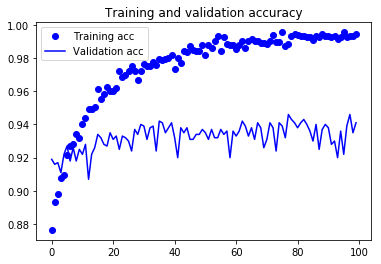

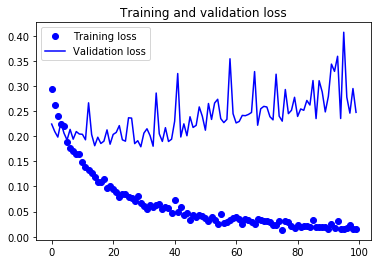

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


These curves look very noisy. To make them more readable, we can smooth them by replacing every loss and accuracy with exponential moving 
averages of these quantities. Here's a trivial utility function to do this:

这些曲线看起来包含噪声。为了让图像更具可读性，你可以将每个损失和精度都替换为指数移动平均值，从而让曲线变得平滑。下面用一个简单的实用函数来实现

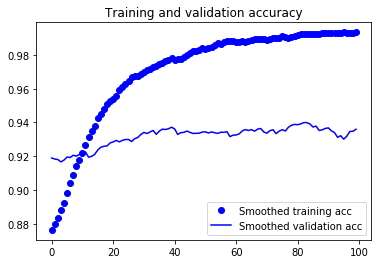

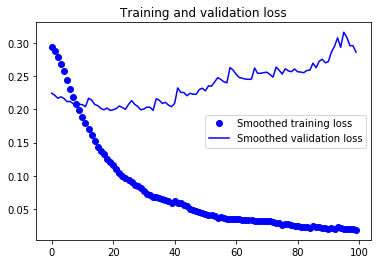

In [29]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


These curves look much cleaner and more stable. We are seeing a nice 1% absolute improvement.

Note that the loss curve does not show any real improvement (in fact, it is deteriorating). You may wonder, how could accuracy improve if the 
loss isn't decreasing? The answer is simple: what we display is an average of pointwise loss values, but what actually matters for accuracy 
is the distribution of the loss values, not their average, since accuracy is the result of a binary thresholding of the class probability 
predicted by the model. The model may still be improving even if this isn't reflected in the average loss.

We can now finally evaluate this model on the test data:

验证精度曲线变得更清楚。可以看到，精度值提高了 1%，从约 96% 提高到 97% 以上。 

注意，从损失曲线上看不出与之前相比有任何真正的提高（实际上还在变差）。你可能感到奇怪，如果损失没有降低，那么精度怎么能保持稳定或提高呢？答案很简单：图中展示的是逐点（pointwise）损失值的平均值，但影响精度的是损失值的分布，而不是平均值，因为精度是模型预测的类别概率的二进制阈值。即使从平均损失中无法看出，但模型也仍然可能在改进。

现在，你可以在测试数据上最终评估这个模型。


In [30]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.938999991417



Here we get a test accuracy of 97%. In the original Kaggle competition around this dataset, this would have been one of the top results. 
However, using modern deep learning techniques, we managed to reach this result using only a very small fraction of the training data 
available (about 10%). There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples!

我们得到了 97% 的测试精度。在关于这个数据集的原始 Kaggle 竞赛中，这个结果是最佳结果之一。但利用现代深度学习技术，你只用一小部分训练数据（约 10%）就得到了这个结果。 训练 20 000 个样本与训练 2000 个样本是有很大差别的！

## Take-aways: using convnets with small datasets

Here's what you should take away from the exercises of these past two sections:

* Convnets are the best type of machine learning models for computer vision tasks. It is possible to train one from scratch even on a very 
small dataset, with decent results.
* On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when working with image 
data.
* It is easy to reuse an existing convnet on a new dataset, via feature extraction. This is a very valuable technique for working with 
small image datasets.
* As a complement to feature extraction, one may use fine-tuning, which adapts to a new problem some of the representations previously 
learned by an existing model. This pushes performance a bit further.

Now you have a solid set of tools for dealing with image classification problems, in particular with small datasets.

## 小结
下面是你应该从以上两节的练习中学到的要点。
* 卷积神经网络是用于计算机视觉任务的最佳机器学习模型。即使在非常小的数据集上也可以从头开始训练一个卷积神经网络，而且得到的结果还不错。
* 在小型数据集上的主要问题是过拟合。在处理图像数据时，数据增强是一种降低过拟合的强大方法。
* 利用特征提取，可以很容易将现有的卷积神经网络复用于新的数据集。对于小型图像数据集，这是一种很有价值的方法。
* 作为特征提取的补充，你还可以使用微调，将现有模型之前学到的一些数据表示应用于新问题。这种方法可以进一步提高模型性能。

现在你已经拥有一套可靠的工具来处理图像分类问题，特别是对于小型数据集。
